# Bayesian Generalized Linear Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

# Introduction

There are a number of packages in the Python ecosystem that are used heavily in statistical modeling. We will make use of several of them (`NumPy`, `pandas`) throughout the course of this chapter, but our main focus here is Bayesian modeling. Specifically we will be focusing on modifying several of our standard statistical methodologies to function within a Bayesian framework. We will discuss why a Bayesian approach is a reasonable one to take and show examples of Generalized Linear Model (GLM) implementation in PyMC3, a probabilistic programming package for defining intuitive hierarchical models. We start with a basic Bayesian linear regression model, explaining the theory, and build up into a hierarchical linear regression model.

## Generalized Linear Models (GLM)

A Generalized Linear Model (GLM) is a blanket term for many of our standard linear models in statistics. The methodology allows for the assignment of arbitrary distributions to response variables, encompassing both linear and logistic regression as well as allowing us to create Bayesian implementations of these classical ideas. Assigning random variables to parameters and outcomes of models in this way is the cornerstone of probabilistic programming.

## PyMC3 - Probabilistic Programming in Python

In probabilistic programming, we define all components of our model in terms of random variables. We apply Bayes' rule to adapt our initial model, incorporating observed data to build a new model to infer unknown causes. Bayes' rule is as follows:

$$ P(\theta\ |\ \mathbf{X}, \alpha) = \frac{P(\mathbf{X}\ |\ \theta)\  P(\theta,\alpha)}{P(\mathbf{X}, \alpha)} \propto P(\mathbf{X}\ |\ \theta)\  P(\theta, \alpha) $$

Bayes' rule allows us to construct a posterior distribution ($P(\theta\ |\ \mathbf{X}, \alpha)$) based on our likelihood ($P(\mathbf{X}\ |\ \theta)$) and prior distribution ($P(\theta, \alpha)$), where $\theta$ is a set of the parameters we have defined for the model with $\alpha$ as the set of parameters for those parameters and $\mathbf{X}$ is a set of our observations. We don't need to worry about $P(\mathbf{X}, \alpha)$ for our purposes as it serves primarily as a normalization factor.

Calculating the posterior distribution directly can be complicated, especially with more complex models that incorporate a lot of hierarchical structure, but we fortunately don't have to deal with that. With probabilistic programming, we define our priors and our likelihood and let a combination of sampling algorithms approximate the posterior! Let's modify our definition of linear regression to incorporate these principles.

## Linear Regression

The first GLM that we will cover is linear regression. Linear regression is a standard quantitative tool in every statistician's toolbox. It provides a simple, easy-to-understand framework for expressing a linear relationship between dependent and independent variables and can be readily applied in many situations. A standard linear regression takes the form of:

$$ Y = X\beta + \epsilon $$

Where $Y$ is the dependent variable, $X$ is our independent variable, $\beta$ are the coefficients for each feature in $X$, and $\epsilon$ is our error, assumed to be normally-distributed.

There are several ways to fit the coefficients. We typically use either Ordinary Least Squares (OLS) or Maximum Likelihood Estimation (MLE).

## Probabilistic Regression

To reformulate this linear regression with a Bayesian methodology, we say that:

$$ Y \sim \mathcal{N}(X\beta, \sigma^2) $$

In other words, we assume that our response variable will follow a normal distribution with mean $X\beta$ and variance $\sigma^2$. With Bayesian inference, the key component is that we define the pieces of our model as probability distributions. This is where PyMC3 comes in. The above is the basic formulation of the model, but *everything* is a probability distribution. All of the parameters of our model will have prior distributions associated with them so we need a way to easily define random variables.

## Advantages of the Bayesian Approach

At the core, both the frequentist and Bayesian approaches try to get at the same solution. They only differ in how they go about it. By incorporating Bayesian statistics into our methodology, we allow for the inclusion of prior distributions. Priors allow us to include our own views about our parameters into the model. 

In addition, the $\beta$ "values" that we calculate through this Bayesian approach are themselves complete posterior distributions instead of point estimates (hence the scare-quotes). A point estimate will have a confidence interval, but an posterior distribution provides us with a much more robust understanding of the uncertainty. We quantify this uncertainty as an intuitive probability distribution.

## Defining a Toy Example

Let's generate some simple data for use with our new approach. Toy examples are always a little boring, but it is important to understand the basic approach before we get into a real world problem.

In [3]:
N = 100
intercept = 1
slope = 2

x = np.random.normal(0, 1, N)
true_line = intercept + slope*x
y = true_line + np.random.normal(0, 0.5, size=N)

data = dict(x=x, y=y)

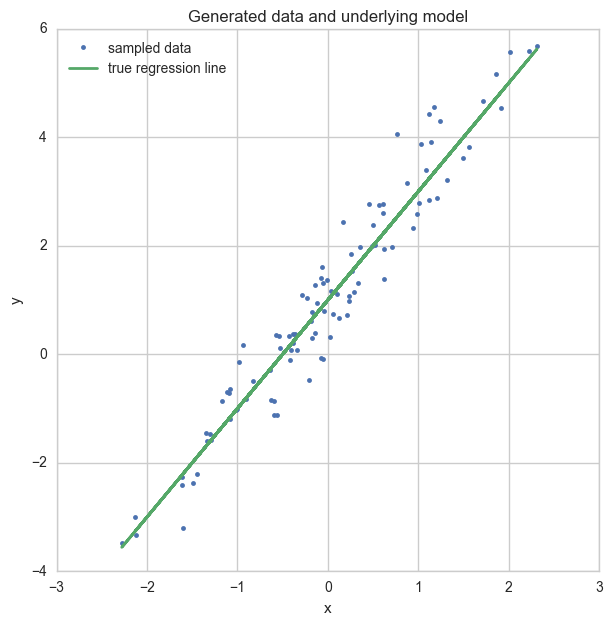

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The data points in this scatter plot are our observed information about the true relationship between $x$ and $y$. This observed information contorts our initial impressions of how our parameters are distributed into our posterior distributions.

## Creating Our Model

Let's define our priors for the Bayesian model. With PyMC3, it is remarkably easy to lay out which components of the model will follow which distributions, however, this may be confusing if you are unfamiliar with the Bayesian framework. The typical model definition is laid out here. In PyMC3, we define all of our variables using the `with` context.

In [5]:
with pm.Model() as model:
    # Defining priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    x_beta = pm.Normal('x', mu=0, sd=20)
    
    # Defining likelihood
    likelihood = pm.Normal('y', mu=(intercept + x_beta * x), sd=sigma, observed=y)
    
    # Running Inference
    trace = pm.sample(2000) # Draw 2000 samples!

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -95.355: 100%|██████████| 200000/200000 [00:14<00:00, 13913.11it/s]
Finished [100%]: Average ELBO = -95.361
100%|██████████| 2000/2000 [00:02<00:00, 862.72it/s] 


If you are less familiar with probabilistic programming, this may look like a lot of nonsense. The syntax for defining probability distributions is intuitive, but this is a lot of extra buzz around the implementation of a basic linear regression. 

For this reason, the PyMC3 developers introduced a `glm` module to simplify the definition of Generalized Linear Models (GLM), including linear regressions such as ours.

In [6]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -116.99: 100%|██████████| 200000/200000 [00:17<00:00, 11392.00it/s]
Finished [100%]: Average ELBO = -116.99
100%|██████████| 2000/2000 [00:02<00:00, 815.70it/s] 


## Basic Diagnostics

We have a few basic things to examine after fitting a Bayesian model. Here are the plots that show our posterior distributions as well as our traceplots: 

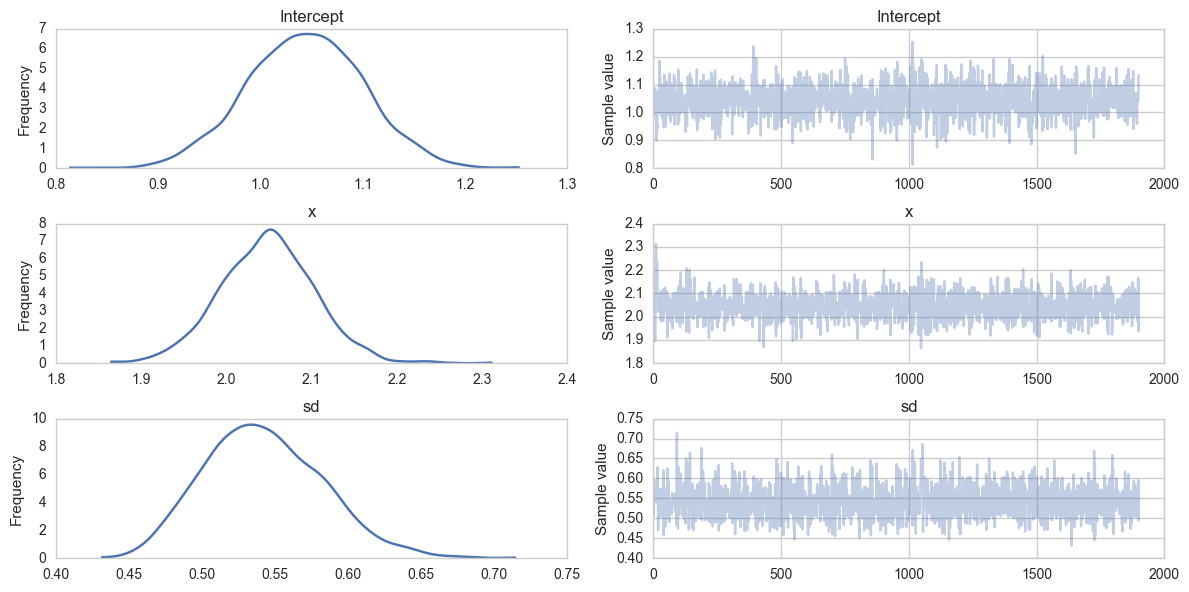

In [7]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

The posterior distributions on the left show how the various components of our regression are distributed after incorporating the observed data.

The traceplots on the right show us whether our traces have converged. The risk with our sampling methods is that we may end up with a bunch of junk values before we have proper samples of the posterior distribution. This is why we only looked at samples *after* the first one hundred, in this case. This is called a **burn-in period**. A non-stationary trace indicates that we need a longer burn-in period.

What's nice here is that the means of our posterior distributions are fairly close to the values that we used to generate the data.

In [8]:
print('-------Means-------')
print('Intercept: ', trace[100:]['Intercept'].mean())
print('x_beta: ', trace[100:]['x'].mean())
print('sd: ', trace[100:]['sd'].mean())

-------Means-------
Intercept:  1.04359619759
x_beta:  2.04760960872
sd:  0.541911060344


In addition to looking at the posterior distributions of our paramaeters, we can also examine the highest posterior density (HPD) interval of each parameter. The HPD is a type of **credible interval**, a Bayesian interval estimate. Credible intervals are not unique, however. As long as a parameter has a probability of $0.95$ to lie within a particular interval, that interval is a $95\%$ credible interval for that parameter. Here we specifically want to look at the $95\%$ HPD interval. This is the narrowest credible interval and it tends to contain the values that have the highest probability density. There are other informative credible intervals, such as the **equal-tailed interval**, where the probability of being below the interval is equal to the probability of being above it, but we only look at the HPD here.

In [9]:
HPD = pm.stats.hpd(trace)
for key, value in HPD.items():
    print(key, " HPD: ", "({0}, {1})".format(value[0], value[1]))

Intercept  HPD:  (0.9377474356486376, 1.1545516260358686)
sd_log_  HPD:  (-0.7568217639057696, -0.4752275282463511)
sd  HPD:  (0.4691551458250764, 0.6217435761446856)
x  HPD:  (1.931993126895957, 2.1488217476719655)


Finally, let's have a look at our response variable. Instead of drawing a single line as with the frequentist approach, here we have a distribution of regression lines. We plot our possibilities by examining the posterior predictive distribution. This entails sampling from our calculated posteriors and drawing regression lines using this new set of samples.

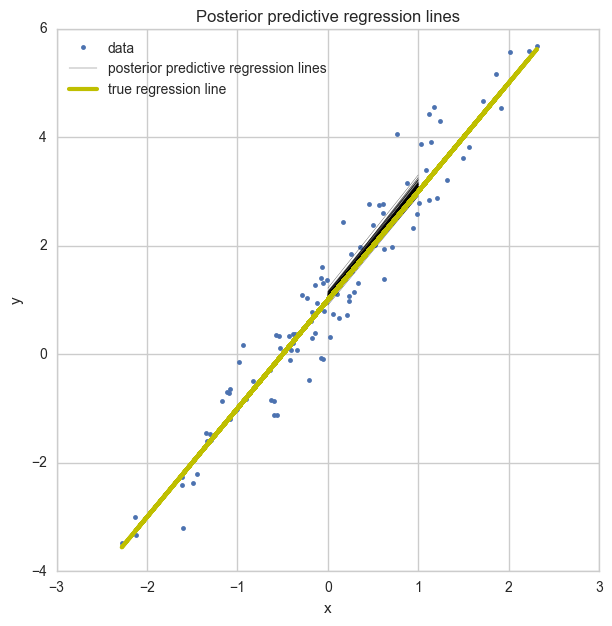

In [10]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

The variation of the lines here (our distribution) give us a measure of uncertainty. By sampling from the posterior distribution, we can define our uncertainty in terms of a probability distribution (or the samples of a probabilitity distribution), the key idea behind Bayesian inference!

## Handling Outliers

Let's make our data set a little weirder. Maybe.

In [11]:
# T Distribution

## Logistic Regression

The next GLM we will cover is logistic regression. Extending logistic regression to work within a Bayesian framework is again simple in PyMC3. Logistic regression is a fan favorite method for classification and is applied in many different situations. It is easy to understand, like linear regression, which is likely a large part of its longetivity in the face of so many powerful machine learning classifiers. Our typical logistic regression looks like this:

$$ F(x) = \frac{1}{1 + e^{X\beta + \epsilon}} $$

Essentially, we take a linear regression and squash it into a logistic function. When we make it Bayesian, we say that:

$$ F \sim \text{Bernoulli}(p),\ \ p = \frac{1}{1 + e^{Y}},\ \ Y \sim \mathcal{N}(X\beta, \sigma^2)$$

We model the outcome as a Bernoulli random variable because this is a classification problem. Bernoulli random variables are binary, taking on a value of $1$ with probability $p$ and taking on a value of $0$ with probability $(1-p)$. The logistic function will output the probability of our model taking on a value of $1$ and we truncate this to either $1$ or $0$. As with the above linear regression, we can  create a Bayesian logistic regression in PyMC3 using the `glm` module.

### Predicting Credit Card Defaults

We will use the "Default of Credit Card Clients" data set from UCI [1] here to develop a logistic model. We pull in the data with `pandas`.

In [11]:
data = pd.read_excel(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
    header=1,
    index_col=0)

In [12]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


For the sake of simplicity, we will drop most of the attributes here so that we only have what we want to actually model. The attribute `BILL_AMT1` contains the credit card bill amount for each individual client in September 2005 and the `PAY_AMT1` variable contains the amount that was paid in September 2005. `EDUCATION` and `MARRIAGE` are each categorical variables that indicate the education level and marital status of each client with an integer code, detailed here:

* EDUCATION: (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* MARRIAGE: (1 = married; 2 = single; 3 = others)

We store whether the client defaulted on a payment as well for our response variable.

In [13]:
default = data['default payment next month']
data = data[['EDUCATION', 'MARRIAGE', 'BILL_AMT1', 'PAY_AMT1']]
data['default'] = default
data = data.dropna()

In [14]:
data.head()

,EDUCATION,MARRIAGE,BILL_AMT1,PAY_AMT1,default
ID,,,,,
1,2,1,3913,0,1
2,2,2,2682,0,1
3,2,2,29239,1518,0
4,2,1,46990,2000,0
5,2,1,8617,2000,0


Here we define the model and sample:

In [16]:
with pm.Model() as logistic_model:
    pm.glm.glm('default ~ EDUCATION + MARRIAGE + BILL_AMT1 + PAY_AMT1', data, family=pm.glm.families.Binomial())
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -99,026: 100%|██████████| 200000/200000 [08:57<00:00, 372.26it/s]    
Finished [100%]: Average ELBO = -98,939
100%|██████████| 3000/3000 [32:51<00:00,  1.52it/s] 


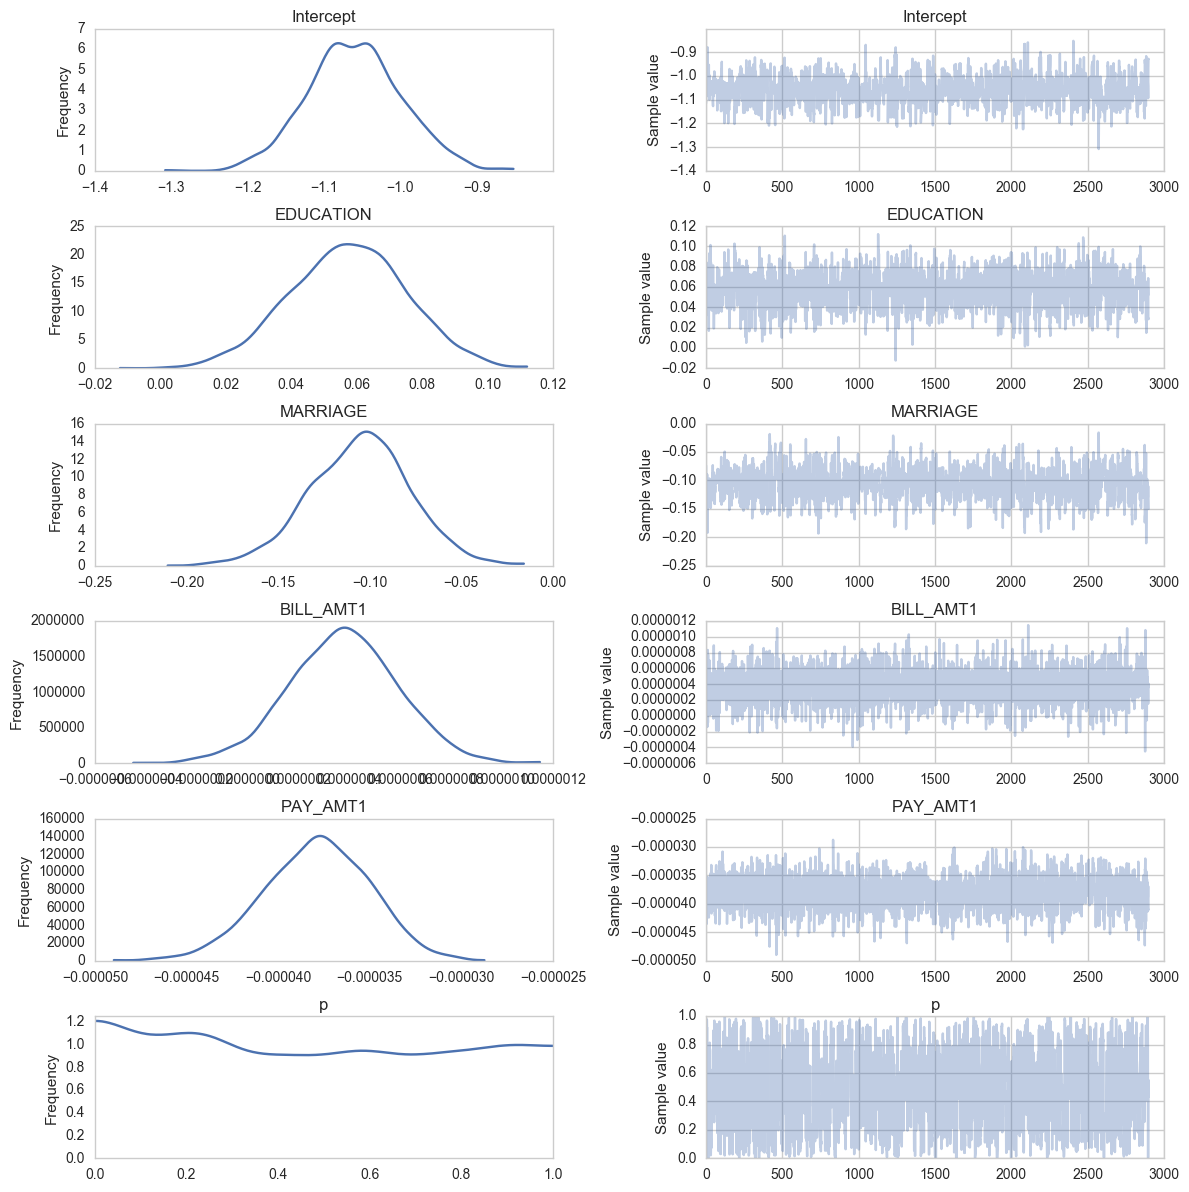

In [17]:
pm.traceplot(trace[100:]);

To generate predictions using our model, we will sample from the posterior distribution. We define some particular instances of our model using lambda functions. We vary the September bill amount of our theoretical clients to see what the default curve would look like for someone who is single, paid $1000 on their September bill, and is of a given education level (which we change for each instance to compare). We want to look at how education and bill amount relate to the probability of default.

In [18]:
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*1 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*2 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['EDUCATION']*3 + 
                                          samples['MARRIAGE']*2 +
                                          samples['BILL_AMT1']*x +
                                          samples['PAY_AMT1']*1000
                                          )))

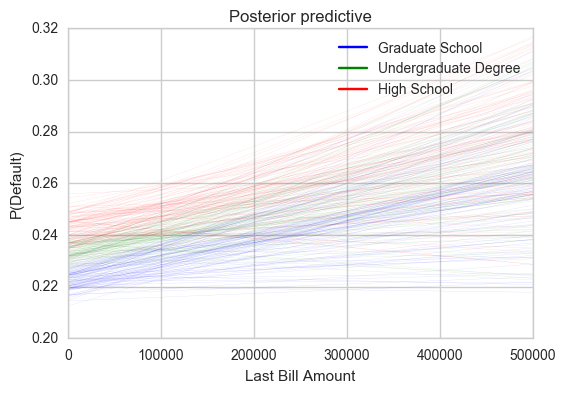

In [19]:
pm.glm.plot_posterior_predictive(trace[100:], eval=np.linspace(0, 500000, 10000), lm=lm, samples=100, color='b', alpha=0.15)
pm.glm.plot_posterior_predictive(trace[100:], eval=np.linspace(0, 500000, 10000), lm=lm2, samples=100, color='g', alpha=0.15)
pm.glm.plot_posterior_predictive(trace[100:], eval=np.linspace(0, 500000, 10000), lm=lm3, samples=100, color='r', alpha=0.15)
import matplotlib.lines as lines
blue_line = lines.Line2D(['lm'], [], color='b', label='Graduate School')
green_line = lines.Line2D(['lm2'], [], color='g', label='Undergraduate Degree')
red_line = lines.Line2D(['lm3'], [], color='r', label='High School')
plt.legend(handles=[blue_line, green_line, red_line], loc='upper right')
plt.ylabel("P(Default)")
plt.xlabel("Last Bill Amount")
plt.show()

A fun part of logistic regression is that if we exponentiate the coefficient of a feature, we get its odds ratio. The odds ratio indicates     We look at the odds ratio of the bill top see how increases in the bill amount affect the probability of default.

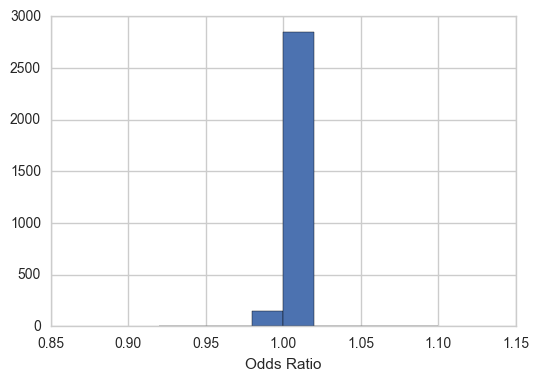

In [20]:
bill_odds = np.exp(trace['BILL_AMT1'])
plt.hist(bill_odds, range=[0.9, 1.1])
plt.xlabel('Odds Ratio');

# Introducing Hierarchical Regression

Let's explore how we could handle a dataset with multiple related componenets. In the stock market, everything exists under the same umbrella, whether we are willing to admit this or not. An incredibly common concept in both fundamental and quantitative finance is the idea of market beta. The market beta of a security is a measure of its exposure to the change in the market. A common way to compute it is to use a linear regression:

$$ R_S = \alpha + \beta_M * R_M + \epsilon $$

Where $R_S$ is the return of your chosen security and $R_M$ is the returns of the market. We want to come up with an estimate, $\hat{\beta}_M$. We generally use the returns of SPY, an ETF that tracks the S&P 500, as our market benchmark.

Here is some code to pull the pricing data and put it into the format we want for PyMC3:

In [ ]:
import datetime
import pandas_datareader.data as web
import pandas as pd
import numpy as np

# Name the stocks we want
stocks = ['GOOG', 'TSLA', 'AAPL', 'AMZN', 'FB']#, 'INTC', 'CSCO', 'MSFT', 'EA']
n_securities = len(stocks)
# Define start and end dates
start_date = "2014-01-01"
end_date = "2015-01-01"
# Name our benchmark and get its returns
spy = web.DataReader('SPY', 'yahoo', start_date, end_date)['Close']
spy = spy.pct_change()[1:]
spy.name = 'SPY'

# Acquire data
returns = pd.DataFrame()
i = 0
for elt in stocks:
    x = web.DataReader(elt, 'yahoo', start_date, end_date)['Close']
    x = x.pct_change()[1:]
    x.name = "Returns"
    symbol = pd.Series(index=x.index, data=elt)
    symbol.name = "Symbol"
    symbol_code = pd.Series(index=x.index, data=i)
    symbol_code.name = "Symbol_Code"
    i+=1
    current_returns = pd.concat([symbol, x, spy, symbol_code], axis=1)
    returns = pd.concat([returns, current_returns])

# Create a dummy variable for each stock symbol
stock_idx = returns.Symbol_Code.values

And this is what our returns data looks like:

In [ ]:
returns.groupby('Symbol').head()

Now that we have our data, we have a few different options for constructing our model.

## Do it all separately!

We can treat each security in our list as an entity totally independent of the others. With this approach, we will calculate a separate $\hat{\beta}_{M,i}$ for each security in our universe. Essentially, with $N$ securities we have:

\begin{eqnarray*}
R_{S_1} &=& \alpha_1 + \beta_{M,1} * R_M + \epsilon_1\\ 
R_{S_2} &=& \alpha_2 + \beta_{M,2} * R_M + \epsilon_2\\
        &\vdots& \\
R_{S_N} &=& \alpha_N + \beta_{M,N} * R_M + \epsilon_N       
\end{eqnarray*}

This is a natural and common approach and is akin to simply repeating our Bayesian linear regression from above $N$ times.

In [ ]:
indiv_traces = {}
for symbol in stocks:
    # Select subset of data belonging to county
    s_data = returns.ix[returns.Symbol == symbol]
    s_spy = s_data.SPY
    
    with pm.Model() as individual:
        # Intercept prior (variance == sd**2)
        a = pm.Normal('alpha', mu=0, sd=100**2)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=100**2)
    
        # Model error prior
        e = pm.Uniform('epsilon', lower=0, upper=10)
    
        # Data likelihood
        exposure_likelihood = pm.Normal('exposure_likelihood',
                                        mu=(a + b * s_spy),
                                        sd=e,
                                        observed=s_data.Returns.values)

        # Inference button (TM)!
        mu, sds, elbo = pm.variational.advi(n=100000)
        step = pm.NUTS(scaling=individual.dict_to_array(sds)**2, is_cov=True)
        trace = pm.sample(5000, step=step, start=mu)
    
    # keep trace for later analysis
    indiv_traces[symbol] = trace


In [ ]:
for symbol in indiv_traces:
    print(indiv_traces[symbol]['beta'].mean())

In [ ]:
for symbol in indiv_traces:
    pm.traceplot(indiv_traces[symbol]);

## Make it hierarchical!

We have only fetched returns data for technology stocks in our example here. This could lead us to think that there is some fundamental relationship that ties all of our stocks together. With 

## Why Hierarchical Regression?

Hierarchical sounds super buzzword-y

There are many situations in real life that lend themselves to a hierarchical regression. 

We have a few different options for implementing something of this nature.

In [ ]:
with pm.Model() as hierarchical:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=10)
    mu_b = pm.Normal('mu_beta', mu=1, sd=10)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=10)
    
    #
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_securities)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_securities)
    e = pm.Normal('epsilon', mu=0, sd=1)
    
    # Data likelihood
    exposure_likelihood = pm.Normal('exposure_likelihood',
                                    mu = alpha[stock_idx] + beta[stock_idx]*returns.SPY.values + e,
                                    observed=returns.Returns.values)

In [ ]:
with hierarchical:
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=hierarchical.dict_to_array(sds)**2, 
                   is_cov=True)
    hierarchical_trace = pm.sample(20000, step, start=mu, njobs=3)

In [ ]:
plt.plot(elbo)
plt.title("ELBO (Evidence Lower Bound)")
plt.ylim(-10000,0);

In [ ]:
help(pm.diagnostics.gelman_rubin)

In [ ]:
pm.diagnostics.gelman_rubin(hierarchical_trace)

In [ ]:
help(pm.diagnostics.geweke)

In [ ]:
pm.diagnostics.geweke(hierarchical_trace)[0]['beta'][0].mean(axis=0)

In [ ]:
hierarchical_trace['beta'].mean(axis=0)

In [ ]:
hierarchical_trace['beta'].mean(axis=0)

In [ ]:
pm.traceplot(hierarchical_trace[500:]);

## Cool, let's use real data

For our example of hierarchical regression, let's use a classic finance example, calculating historical market beta. 

Let's pull prices for a few stocks in the tech industry as well as the S&P500.

We can estimate individual regressions for each stock to calculate their market beta or we can make it hierarchical.

## Non-linear Models

## Citations

[1] Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.